In [469]:
! pip3 install pandas matplotlib seaborn scikit-learn
! pip3 install nltk
! pip3 install spacy
! pip3 install wordcloud


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip


## Imports

In [470]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.tokenize import word_tokenize
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from wordcloud import WordCloud

nltk.download('punkt')
nltk.download('stopwords')

ORIGINAL_DATASET_PATH = "../dataset/fake_job_postings.csv"

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/cynaracosta/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/cynaracosta/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Data set description

Title → The title or name of the job position being advertised.

Location → The location(s) where the job is based or available. This could include cities, states, or countries.

Department → The specific department or division within the organization to which the job role belongs.

Salary Range → The range of salaries offered for the job position, typically specified as a minimum and maximum value.

Company Profile → A description of the hiring company, including its background, mission, values, products, and services.

Description → A detailed description of the job role, responsibilities, duties, and qualifications required.

Requirements → Specific requirements or qualifications that candidates must meet to be considered for the job, such as education, experience, skills, certifications, etc.

Benefits → Any additional benefits or perks offered to employees, such as health insurance, retirement plans, vacation days, etc.

Telecommuting → Indicates whether the job offers telecommuting or remote work options (1 for yes, 0 for no).

Has Company Logo → Indicates whether the job posting includes the company's logo (1 for yes, 0 for no).

Has Questions → Indicates whether the job posting includes screening questions for applicants (1 for yes, 0 for no).

Employment Type → The type of employment offered for the job, such as full-time, part-time, contract, temporary, etc.

Required Experience → The level of experience required for the job role, such as entry-level, mid-level, senior-level, etc.

Required Education → The minimum education level required for the job, such as high school diploma, bachelor's degree, master's degree, etc.

Industry → The industry or sector to which the job role belongs, such as technology, finance, healthcare, etc.

Function → The specific function or area of specialization within the industry, such as sales, marketing, engineering, etc.

Fraudulent → Indicates whether the job posting is flagged as fraudulent (1 for yes, 0 for no).

## Treating data

In [471]:
data = pd.read_csv(ORIGINAL_DATASET_PATH)

data.head(1)

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0


In [472]:
# Drop job_id
data = data.drop(columns=['job_id'])

In [473]:
# Checks duplicates -> tem 281 
data.duplicated().sum()

data = data.drop_duplicates()

# Removed all
data.duplicated().sum()

0

In [474]:
# Check percentage of null value from the features
data.isnull().sum()/len(data)*100

title                   0.000000
location                1.937610
department             64.367294
salary_range           83.936587
company_profile        18.648787
description             0.005682
requirements           15.051992
benefits               40.388658
telecommuting           0.000000
has_company_logo        0.000000
has_questions           0.000000
employment_type        19.478379
required_experience    39.559066
required_education     45.508268
industry               27.484516
function               36.155463
fraudulent              0.000000
dtype: float64

Making DF for Categorical and Numerical Columns

In [475]:
data.select_dtypes(include='object').columns

Index(['title', 'location', 'department', 'salary_range', 'company_profile',
       'description', 'requirements', 'benefits', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function'],
      dtype='object')

After the percentage we got from the null info from each feature, we can see that salary_range has more than 80% of null data, which means theres not enough information for us to consider at the training, so we drop this feature from our dataframe

In [476]:
# Calling Categorical Columns
object_columns_df = data.select_dtypes(include='object')

# Removing the salary_range feature from our df
data = data.drop(columns=['salary_range'])
object_columns_df = object_columns_df.drop(columns='salary_range')
object_columns_df.head()

,title,location,department,company_profile,description,requirements,benefits,employment_type,required_experience,required_education,industry,function
0,Marketing Intern,"US, NY, New York",Marketing,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,Other,Internship,NaN,NaN,Marketing
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,NaN,NaN,NaN,NaN,NaN
3,Account Executive - Washington DC,"US, DC, Washington",Sales,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales
4,Bill Review Manager,"US, FL, Fort Worth",NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider


In [477]:
# Calling Numerical Columns
data.select_dtypes(include=int).columns

Index(['telecommuting', 'has_company_logo', 'has_questions', 'fraudulent'], dtype='object')

In [478]:
numerical_columns_df = data.select_dtypes(include=int)
numerical_columns_df.head()

,telecommuting,has_company_logo,has_questions,fraudulent
0,0,1,0,0
1,0,1,0,0
2,0,1,0,0
3,0,1,0,0
4,0,1,1,0


### Some Data Visualization

Counts of Fraudulent vs Non-Fraudulent

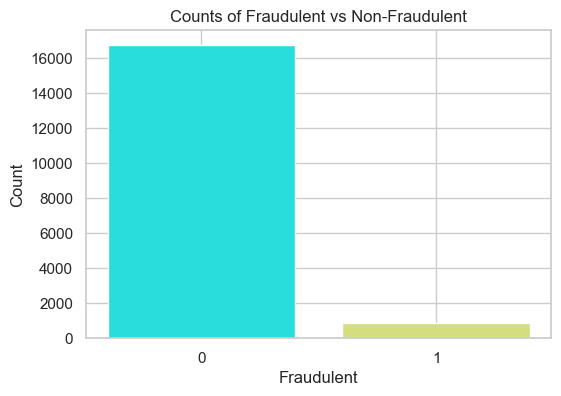

In [479]:
# Counts of Fraudulent vs Non-Fraudulent
fraudulent_counts = data['fraudulent'].value_counts()

plt.figure(figsize=(6,4))
colors = sns.color_palette('rainbow', n_colors=len(fraudulent_counts))
bars = plt.bar(fraudulent_counts.index, fraudulent_counts.values, color=colors)
plt.xlabel('Fraudulent')
plt.ylabel('Count')
plt.title('Counts of Fraudulent vs Non-Fraudulent')

# limiting the x for the 0 and 1 interval
plt.xticks([0,1], fraudulent_counts.index)

plt.show()


Counts of telecommuting vs Non-telecommuting

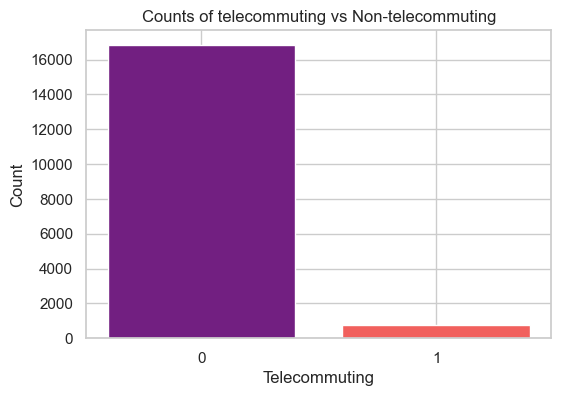

In [480]:
# Counts of telecommuting vs Non-telecommuting
telecommuting_counts = data['telecommuting'].value_counts()

plt.figure(figsize=(6,4))
colors = sns.color_palette('magma', n_colors=len(telecommuting_counts))
bars = plt.bar(telecommuting_counts.index, telecommuting_counts.values, color=colors)
plt.xlabel('Telecommuting')
plt.ylabel('Count')
plt.title('Counts of telecommuting vs Non-telecommuting')

# limiting the x for the 0 and 1 interval
plt.xticks([0,1], telecommuting_counts.index)

plt.show()


Counts of With_Logo vs Without_Logo

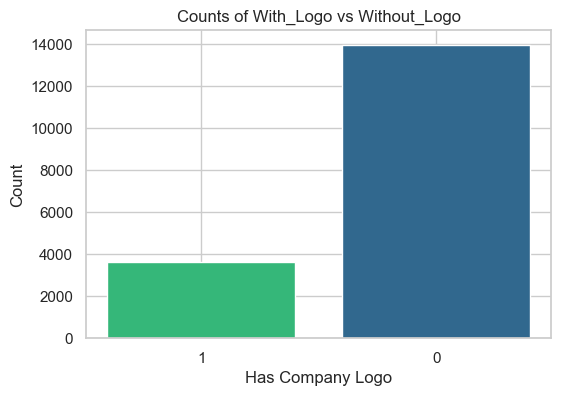

In [481]:
# Counts of With_Logo vs Without_Logo
has_company_logo_counts = data['has_company_logo'].value_counts()

plt.figure(figsize=(6,4))
colors = sns.color_palette('viridis', n_colors=len(has_company_logo_counts))
bars = plt.bar(has_company_logo_counts.index, has_company_logo_counts.values, color=colors)
plt.xlabel('Has Company Logo')
plt.ylabel('Count')
plt.title('Counts of With_Logo vs Without_Logo')

# limiting the x for the 0 and 1 interval
plt.xticks([0,1], has_company_logo_counts.index)

plt.show()


Distribution of Employment Type

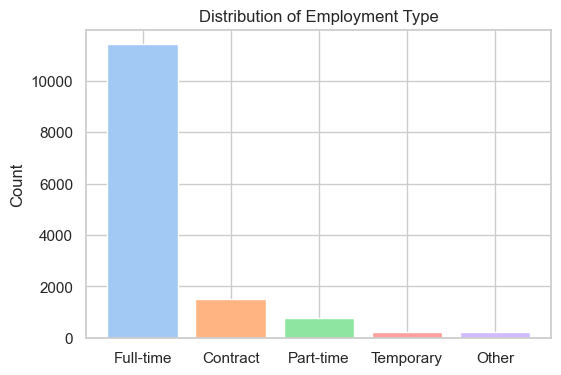

In [482]:
# Distribution of Employment Type
employment_type_counts = data['employment_type'].value_counts()

plt.figure(figsize=(6,4))
colors = sns.color_palette('pastel', n_colors=len(employment_type_counts))
bars = plt.bar(employment_type_counts.index, employment_type_counts.values, color=colors)
plt.ylabel('Count')
plt.title('Distribution of Employment Type')

plt.show()


Distribution of Required Experience

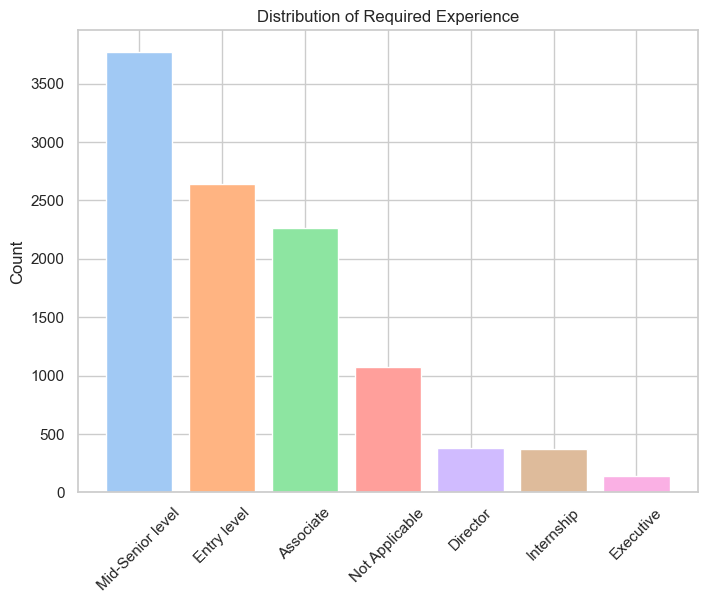

In [483]:
# Distribution of Required Experience
required_experience_counts = data['required_experience'].value_counts()

plt.figure(figsize=(8,6))
colors = sns.color_palette('pastel', n_colors=len(required_experience_counts))
bars = plt.bar(required_experience_counts.index, required_experience_counts.values, color=colors)
plt.ylabel('Count')
plt.title('Distribution of Required Experience')
plt.xticks(rotation=45)

plt.show()

### Dealing with missing values

In [484]:
data.isnull().sum()

title                      0
location                 341
department             11328
company_profile         3282
description                1
requirements            2649
benefits                7108
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3428
required_experience     6962
required_education      8009
industry                4837
function                6363
fraudulent                 0
dtype: int64

In [485]:
# Let's fill them with empty value
data.fillna('', inplace = True)
data.isnull().sum()

title                  0
location               0
department             0
company_profile        0
description            0
requirements           0
benefits               0
telecommuting          0
has_company_logo       0
has_questions          0
employment_type        0
required_experience    0
required_education     0
industry               0
function               0
fraudulent             0
dtype: int64

### Concatenating the object coluns for a Text column and treating the text data for use when we are training the model

In [486]:
data['text'] = data[object_columns_df.columns].apply(lambda x: ' '.join(x.dropna().astype(str)), axis=1)

data.head(2)

,title,location,department,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,text
0,Marketing Intern,"US, NY, New York",Marketing,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,0,1,0,Other,Internship,,,Marketing,0,"Marketing Intern US, NY, New York Marketing We..."
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,,Marketing and Advertising,Customer Service,0,"Customer Service - Cloud Video Production NZ, ..."


Creating a Stopwords for fake and real job posting

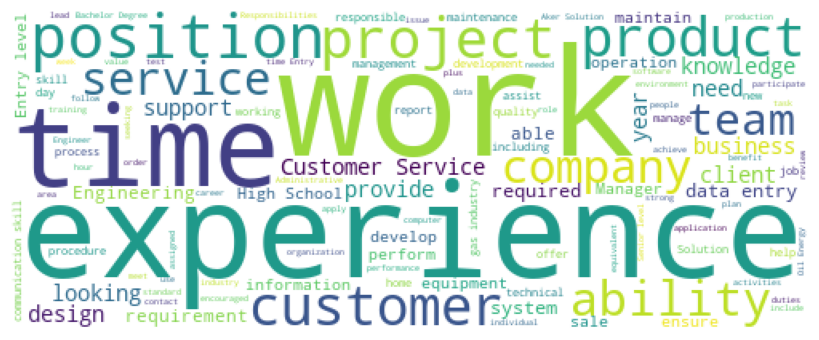

In [487]:
# fake
fake_data = data[data['fraudulent']==1]['text']

STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS
wordcloud = WordCloud(min_font_size=4,width=500, height=200, background_color='white',stopwords=STOPWORDS).generate(' '.join(fake_data))
plt.figure(figsize=(8,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

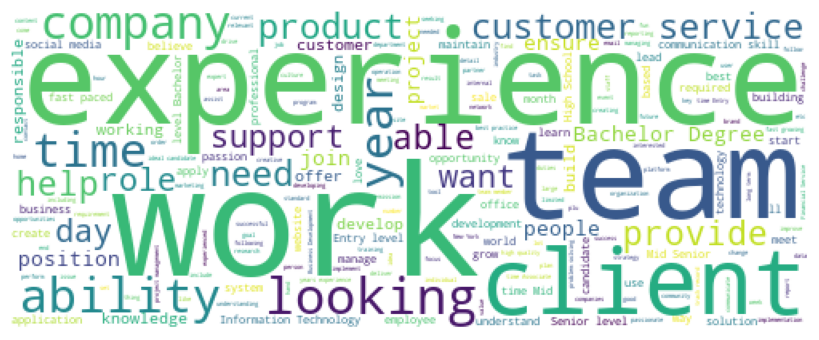

In [488]:
# real
real_data = data[data['fraudulent']==0]['text']

STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS
wordcloud = WordCloud(min_font_size=4,width=500, height=200, background_color='white',stopwords=STOPWORDS).generate(' '.join(real_data))
plt.figure(figsize=(8,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

### Data cleaning - text

In [489]:
def clean_text(text):
    
    text = text.lower() # everything for minuscule
    text = re.sub(r'<.*?>', '', text) # remove tags hml
    text = re.sub(r'http\S+', '', text) # remove url
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text) # remove non alfa number characters
    # now we tokenize the words, for transforming frases to array of words
    tokens = nltk.word_tokenize(text)
    # remove stop words like 'the' 'an'
    stop_words = set(nltk.corpus.stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # gathering them all 
    cleaned_text = ' '.join(tokens)
    
    return cleaned_text

In [490]:
data['text'] = data['text'].apply(clean_text)
data.head()

,title,location,department,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,text
0,Marketing Intern,"US, NY, New York",Marketing,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,0,1,0,Other,Internship,,,Marketing,0,marketing intern us ny new york marketing food...
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,,Marketing and Advertising,Customer Service,0,customer service cloud video production nz auc...
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,0,1,0,,,,,,0,commissioning machinery assistant cma us ia we...
3,Account Executive - Washington DC,"US, DC, Washington",Sales,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,account executive washington dc us dc washingt...
4,Bill Review Manager,"US, FL, Fort Worth",,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,bill review manager us fl fort worth spotsourc...


In [491]:
# Now let's remove all the others object columns because they are all gathered at the text column
data = data.drop(columns=object_columns_df.columns)
# Lets add one more column for getting the length from the text for each job posting
data['text_len'] = data['text'].str.len()
data.head()

,telecommuting,has_company_logo,has_questions,fraudulent,text,text_len
0,0,1,0,0,marketing intern us ny new york marketing food...,2092
1,0,1,0,0,customer service cloud video production nz auc...,4369
2,0,1,0,0,commissioning machinery assistant cma us ia we...,2053
3,0,1,0,0,account executive washington dc us dc washingt...,4581
4,0,1,1,0,bill review manager us fl fort worth spotsourc...,3420


<Axes: xlabel='text_len', ylabel='Count'>

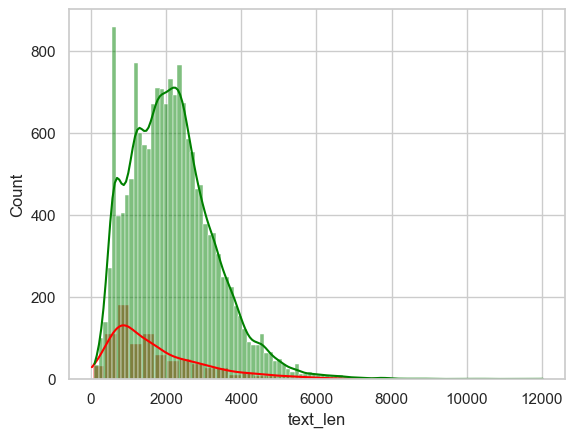

In [498]:
sns.histplot(x=data[data["fraudulent"]==1]["text_len"],kde=True, color="red")
sns.histplot(x=data[data["fraudulent"]==0]["text_len"],kde=True,color="green")

We can see from the graphs above that the real job posting have much more information against the fake ones